In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import math


# SimPEG imports
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh


# SBI imports
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis


## Schlumberger Array 
Experiment Setup of the 1D DC resistivity measurements of the layered Earth model. 
Define Schlumberger Array according to min_distance, max_distance, the spacing and the number of measurements. 



In [2]:
def schlumberger_survey(num_measurements, min_ab_distance, max_ab_distance, spacing='log'):
    # Define the 'a' spacing for Schlumberger array measurements for each reading 
    if spacing == 'log': 
        a_b_electrode_separations = np.logspace(np.log10(min_ab_distance), np.log10(max_ab_distance), num_measurements)
        m_n_electrode_separations = 0.01 * a_b_electrode_separations 
    elif spacing == 'lin': 
        a_b_electrode_separations = np.linspace(min_ab_distance, max_ab_distance, num_measurements)
        m_n_electrode_separations = 0.01 * a_b_electrode_separations 
    else:
        raise Exception('Invalid Spacing - needs to be a string of either "log" or "lin" but it was given', spacing)
        
    
    source_list_log = []  # create empty array for sources to live
    
    for ab, mn in zip(a_b_electrode_separations, m_n_electrode_separations):
    
    
        # AB electrode locations for source. Each is a (1, 3) numpy array
        A_location = np.r_[-ab, 0.0, 0.0]
        B_location = np.r_[ab, 0.0, 0.0]
    
        # MN electrode locations for receivers. Each is an (N, 3) numpy array
        M_location = np.r_[-mn, 0.0, 0.0]
        N_location = np.r_[mn, 0.0, 0.0]
    
        # Create receivers list. Define as pole or dipole.
        receiver_list = dc.receivers.Dipole(
            M_location, N_location, data_type="apparent_resistivity"
        )
        receiver_list = [receiver_list]
    
        # Define the source properties and associated receivers
        source_list_log.append(dc.sources.Dipole(receiver_list, A_location, B_location))
    
    # Define survey
    survey = dc.Survey(source_list_log)
    
    electrode_separations = 0.5 * np.sqrt(
        np.sum((survey.locations_a - survey.locations_b) ** 2, axis=1)
        
    )
    return survey, electrode_separations

## Forward model wrapper

According to the survey setup from above we have the electrode spacing. Now we define a wrapper for the actual forward model such that it receives the thicknesses and the respective resistivities of the individual layers of th e

In [3]:
# Note parameters are composed of resistivities and thicknesses - in that order. First resistivities then thicknesses
def dc_forward_model(resistivities, thicknesses, survey):
        
    # Define mapping from model to 1D layers.
    model_map = maps.IdentityMap(nP=len(resistivities))
    # SimPegs 1D Simulation 
    simulation = dc.simulation_1d.Simulation1DLayers(
        survey=survey,
        rhoMap=model_map,
        thicknesses=thicknesses,
    )
    
    # Predict data for a given model
    pred = simulation.dpred(resistivities)
    return pred

In [4]:
def dc_forward_model_for_sbi (params, survey):
    # Split params into resistivities and thicknesses
    param_length = len(params)
    number_of_layers = int((param_length+1)/2)
    # First half of parameters is resistivities
    resistivities = params[:number_of_layers]
    # Second half of parameters are thicknesses
    thicknesses = params[number_of_layers:]
        
    return dc_forward_model(resistivities, thicknesses, survey)

## Forward Simulation - Textbook example
The Textbook referred to is "Resistivity and Induced Polarization Theory and Applications to the Near-Surface Earth" 
The example referred to is the one in Chapter 4, Figure 4.9 
In this example we have a three layered earth model with the following resistivity values [500$\Omega m$, 200$\Omega m$, 500$\Omega m$ / 50$\Omega m$].
In this model we assume an infinite base layer and the thickness of the first two layers are 5m for the first layer, 10m for the second layer 

In [5]:
num_measurements = 20
min_spacing = 1
max_spacing = 1000
earth_resistivities = [500,200,50]
earth_layer_thicknesses = [5,10,]


textbook_survey, textbook_electrode_spacing = schlumberger_survey(num_measurements, min_spacing, max_spacing)
apparent_resistivities_textbook = dc_forward_model(earth_resistivities, earth_layer_thicknesses, textbook_survey)

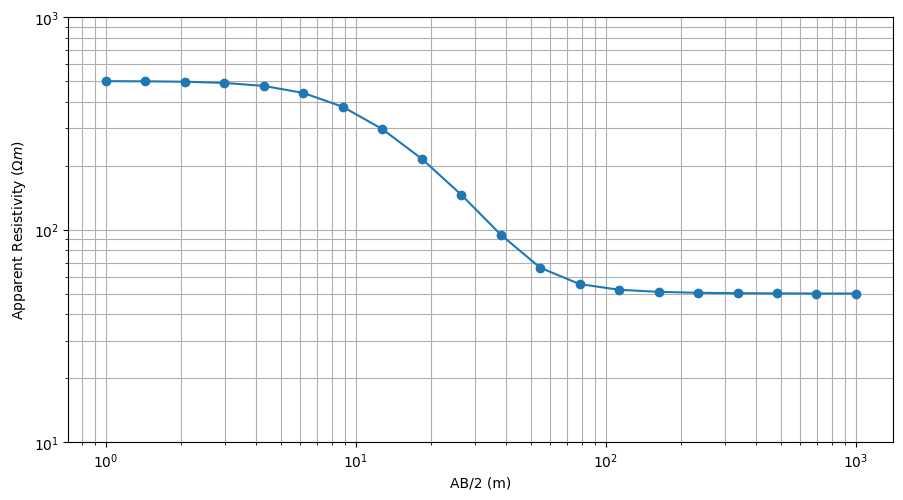

In [6]:
# Plot apparent resistivities on sounding curve# Plot apparent resistivities on sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook, marker='o', label="$50 \Omega m$) lower unit")
ax1.set_ylim([10, 1000])
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.grid(True, which="both", ls="-")
plt.show()

## SBI Inversion - Textbook example

In the following sections we try to infer the earth_resistivities and earth_layer_thicknesses and assume we only measured the apparent resistivities ( the same ones we just now simulated by the forward model)
As SBI struggles a bit to infer the resistivities of the DC resistivity model I used different approaches to see where the problems actually come form. 

We start by defining some helper functions and then trying several approaches 

1. Standard approach - 20 measurement points  1000 simulations
2. Extensive approach - 100 measurement points - 10000 simulations
3. Adding noise to standard approach - 20 measurements 1000simulations 0 
4. Limiting the prior - 20 measurements 1000 simulations prior from 0 - 1000
5. Limiting the prior while running more simulations - 20 measurements 5000 simulations prior 0-1000
6. Limiting the measurement distance up to 250m instead of 1000m - 20 measurements 5000 simulations prior 0 - 1000

In [11]:
def dc_forward_model_for_sbi_fixed_resistivities(resistivities):
    return dc_forward_model(resistivities, earth_layer_thicknesses, textbook_survey)
    

In [12]:
def sbi_wrapper(simulator, prior, num_simulations): 
    # Initialise an SNPE inference object
    inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)
    # Simulate the forward model num_simulations many times from the wrapped forward model an
    theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_simulations)    
    # Pass the simulated data in pairs of parameters theta and simulated data x to the inference object
    inference = inference.append_simulations(theta, x)
    # Train the inference object
    density_estimator = inference.train()
    # Build posterior from the inference object
    posterior = inference.build_posterior(density_estimator)

    return posterior, theta, x, inference
    

In [14]:
def pickle_objects (objects, filename):
    with open(filename, "wb") as f:
        pickle.dump(objects, f)
    
def unpickle_objects (filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

In [28]:
def add_noise(apparent_resistivities): 
    return [max(0.0, (np.random.normal(num, num * 0.05, 1)[0])) for num in apparent_resistivities]

### 1. Standard SNPE approach with 1000 simulations 

In [22]:
infer_model = False

filename_experiment_1 = "pickle/sbi_models/1__ptx_20meas_1000sim_5000prior.pkl"

if infer_model: 

    num_dim = 3
    prior_min = torch.as_tensor([0,0,0])
    prior_max = torch.as_tensor([5000,5000,5000])
    
    # Define the prior as a BoxUniform distribution
    prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))
    # Define the prior and the simulator for sampling based on the wrapped forward model and the prior
    simulator, prior = prepare_for_sbi(dc_forward_model_for_sbi_fixed_resistivities, prior)
    # Compute posterior, as well as parameters and trajectories of the simulations
    posterior__1, theta__1, x__1, _ = sbi_wrapper(simulator, prior, 1000)
    pickle_objects([posterior__1, theta__1, x__1], filename_experiment_1)
    
else:
    posterior__1, theta__1, x__1 = unpickle_objects(filename_experiment_1)

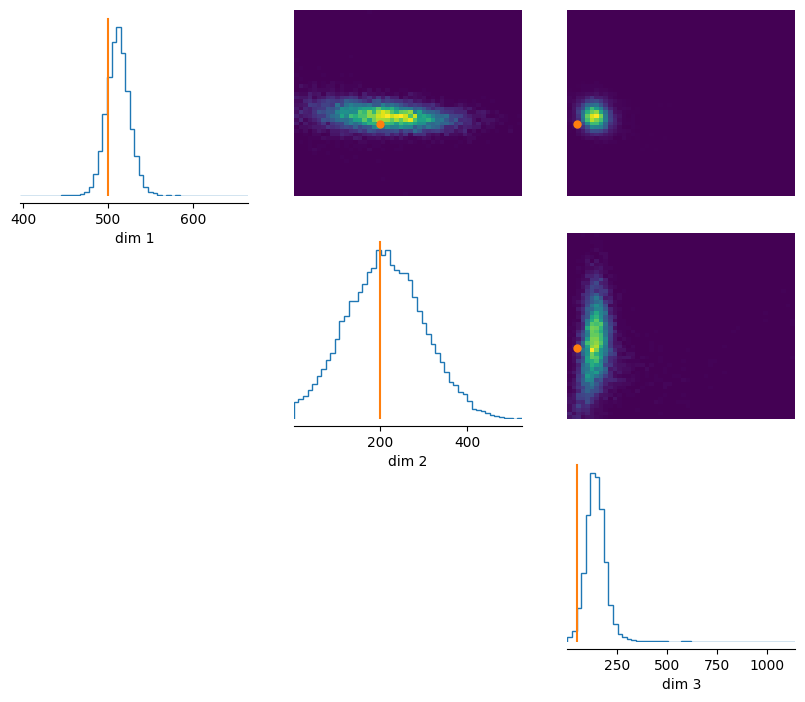

In [23]:
# Sample from the posterior distribution
posterior_samples = posterior__1.sample((10000,), x=apparent_resistivities_textbook, show_progress_bars=False)
# plot Posterior samples
_ = analysis.pairplot(posterior_samples,points= torch.tensor([500,200, 50]), figsize=(10,8))

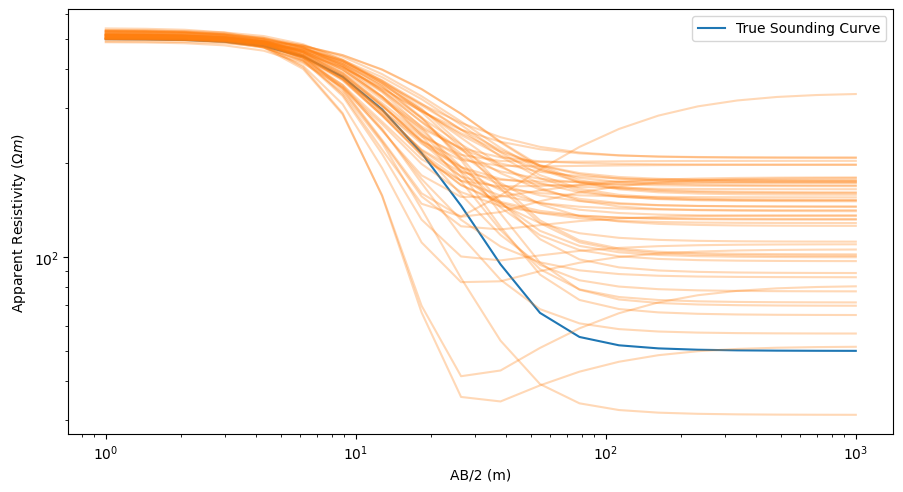

In [24]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing, app_res, color='#ff7f0e',  alpha=0.3)
  


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()


### 2. Extensive SNPE approach with 100 measurements and 10000 simulations 

In [9]:
num_measurements = 100
textbook_survey_100, textbook_electrode_spacing_100 = schlumberger_survey(num_measurements, min_spacing, max_spacing)
apparent_resistivities_textbook_100 = dc_forward_model(earth_resistivities, earth_layer_thicknesses, textbook_survey_100)
    
def dc_forward_model_for_sbi_fixed_resistivities_100(resistivities):
    return dc_forward_model(resistivities, earth_layer_thicknesses, textbook_survey_100)

In [27]:
infer_model = False
filename_experiment_2 = "pickle/sbi_models/2__ptx_100meas_10000sim_5000prior.pkl"

if infer_model:
    num_dim = 3
    prior_min = torch.as_tensor([0, 0, 0 ])
    prior_max = torch.as_tensor([5000, 5000, 5000 ])
    
    # Define the prior and the simulator for sampling based on the wrapped forward model and the prior
    prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))
    simulator, prior = prepare_for_sbi(dc_forward_model_for_sbi_fixed_resistivities_100, prior)
    inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)
    theta__2, x__2 = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000)
    
    inference = inference.append_simulations(theta__2, x__2)
    density_estimator = inference.train()
    
    posterior__2 = inference.build_posterior(density_estimator)
    
    pickle_objects([posterior__2, theta__2, x__2], filename_experiment_2)
    
else:
    posterior__2, theta__2, x__2 = unpickle_objects(filename_experiment_2)
    

FileNotFoundError: [Errno 2] No such file or directory: 'pickle/sbi_models/2__ptx_100meas_10000sim_5000prior.pkl'

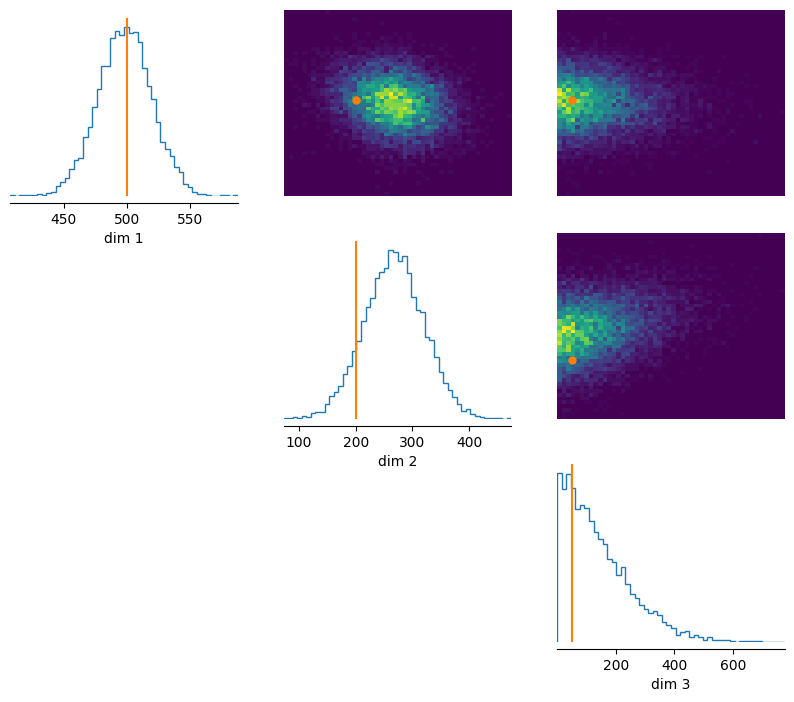

In [12]:
posterior_samples = posterior__2.sample((10000,), x=apparent_resistivities_textbook_100, show_progress_bars=False)
# plot Posterior samples
_ = analysis.pairplot(posterior_samples, points= torch.tensor([500,200, 50]), figsize=(10,8))

### 3. Adding Noise to the model to make it more robust 
In this section a guassian noise of 5% of the magnitude of the current value is added to the synthetic signal generated form the thextbook example. 




In [29]:
apparent_resistivities_textbook_noise = add_noise(apparent_resistivities_textbook)

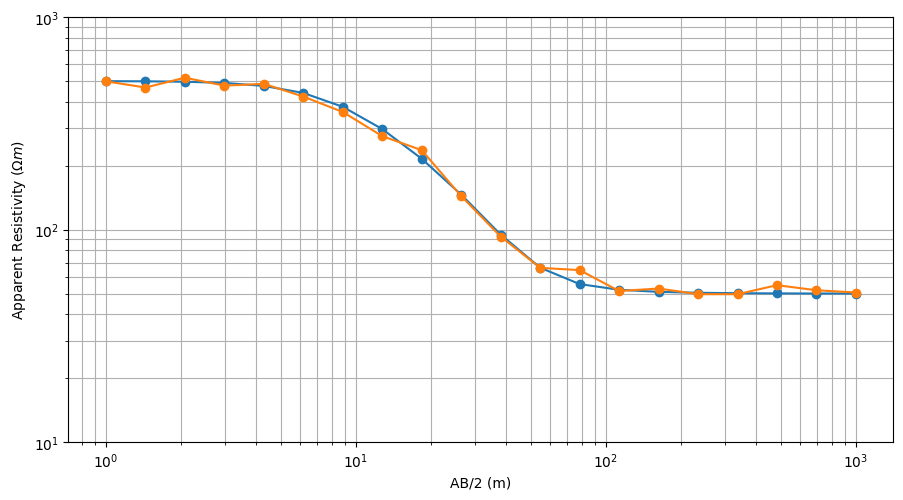

In [30]:
# Plot apparent resistivities on sounding curve# Plot apparent resistivities on sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook, marker='o', label="$50 \Omega m$) lower unit")
ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook_noise, marker='o', label="$50 \Omega m$) lower unit")
ax1.set_ylim([10, 1000])
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.grid(True, which="both", ls="-")
plt.show()

In [31]:
posterior_samples_no_noise = posterior__1.sample((10000,), x=apparent_resistivities_textbook, show_progress_bars=False)
posterior_samples_noise = posterior__1.sample((10000,), x=apparent_resistivities_textbook_noise, show_progress_bars=False)

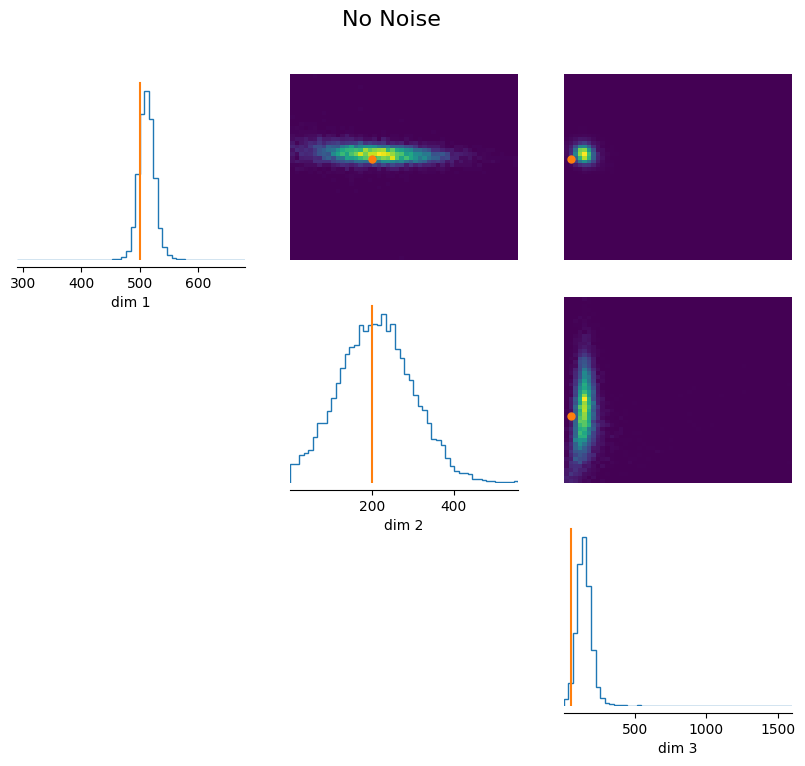

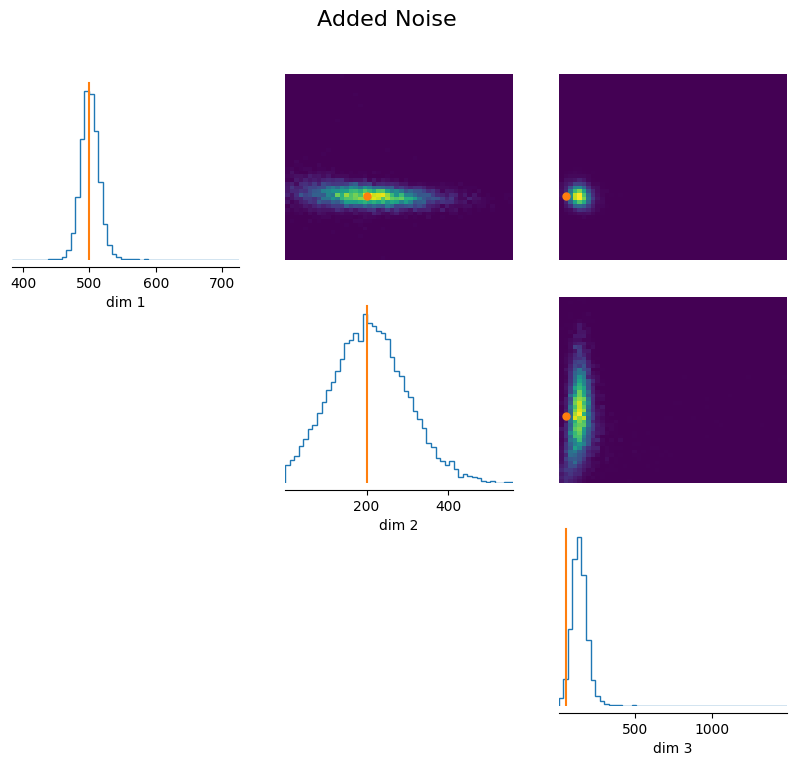

In [42]:
no_noise_plot = analysis.pairplot(posterior_samples_no_noise, points= torch.tensor([500,200, 50]), figsize=(10,8), title="No Noise")
noise_plot =  analysis.pairplot(posterior_samples_noise,points= torch.tensor([500,200, 50]), figsize=(10,8), title="Added Noise")

### 4. Limiting the range of the prior

In [50]:
infer_model = False
filename_experiment_4 = "pickle/sbi_models/4__ptx_20meas_1000sim_1000prior.pkl"

if infer_model:

    num_dim = 3
    prior_min = torch.as_tensor([0,0,0])
    prior_max = torch.as_tensor([1000,1000,1000])
    
    # Define the prior as a BoxUniform distribution
    prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))
    # Define the prior and the simulator for sampling based on the wrapped forward model and the prior
    
    simulator, prior = prepare_for_sbi(dc_forward_model_for_sbi_fixed_resistivities, prior)
    
    posterior__4, theta__4, x__4, _ = sbi_wrapper(simulator, prior, 1000)
    
    pickle_objects([posterior__4, theta__4, x__4], filename_experiment_4)
    
else:
    posterior__4, theta__4, x__4 = unpickle_objects(filename_experiment_4)
    

### Sampling and pairplotting based on the measurements without noise

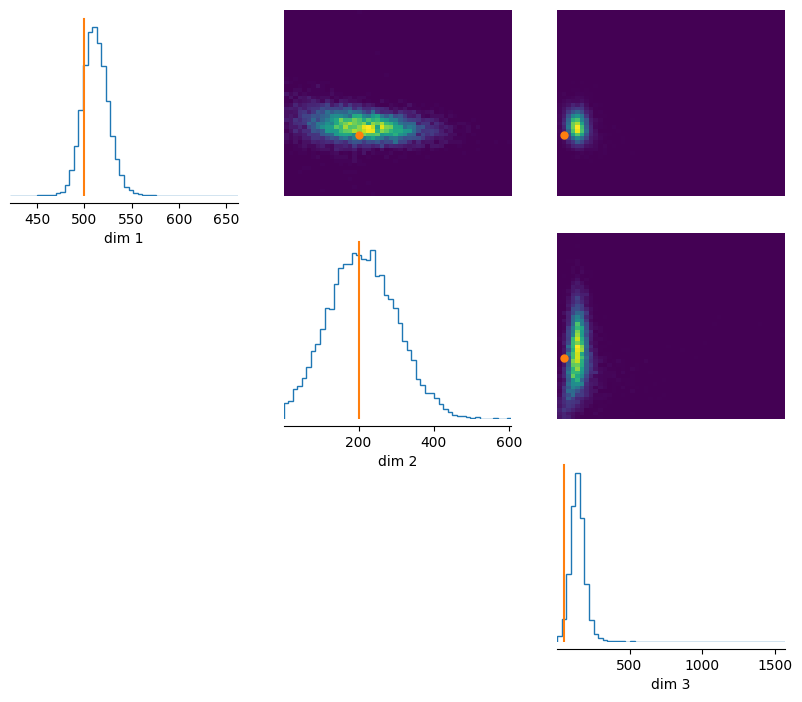

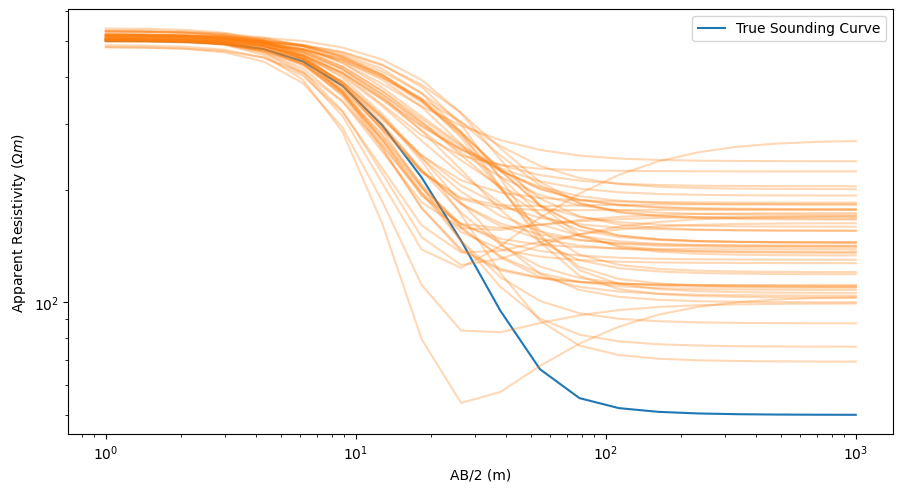

In [51]:
# Sample from the posterior distribution
posterior_samples_no_noise = posterior__4.sample((10000,), x=apparent_resistivities_textbook, show_progress_bars=False)
# plot Posterior samples
_ = analysis.pairplot(posterior_samples_no_noise,points= torch.tensor([500,200, 50]), figsize=(10,8))

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples_no_noise[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing, app_res, color='#ff7f0e',  alpha=0.3)
  


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()


### Sampling and pairplotting based on the measurements with added noise

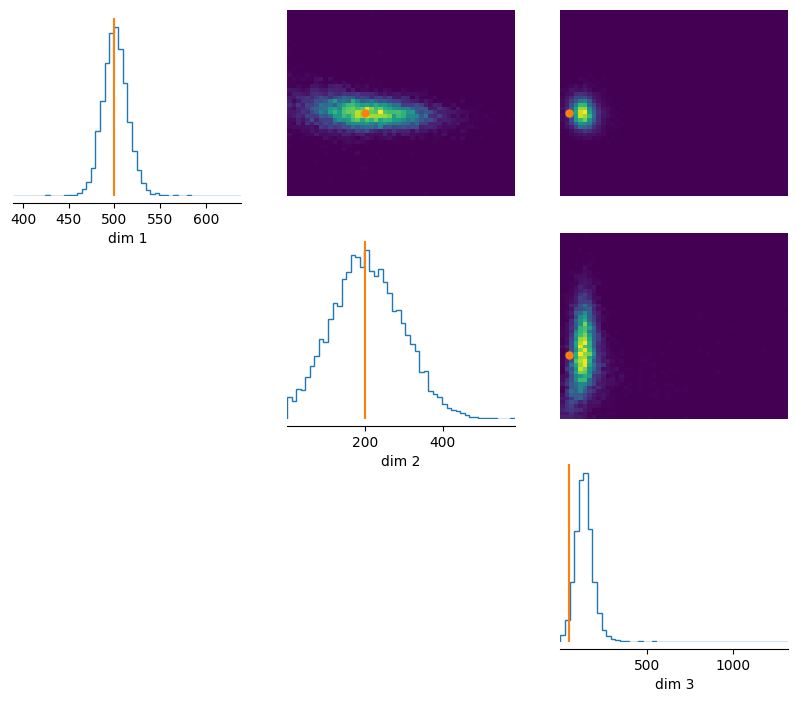

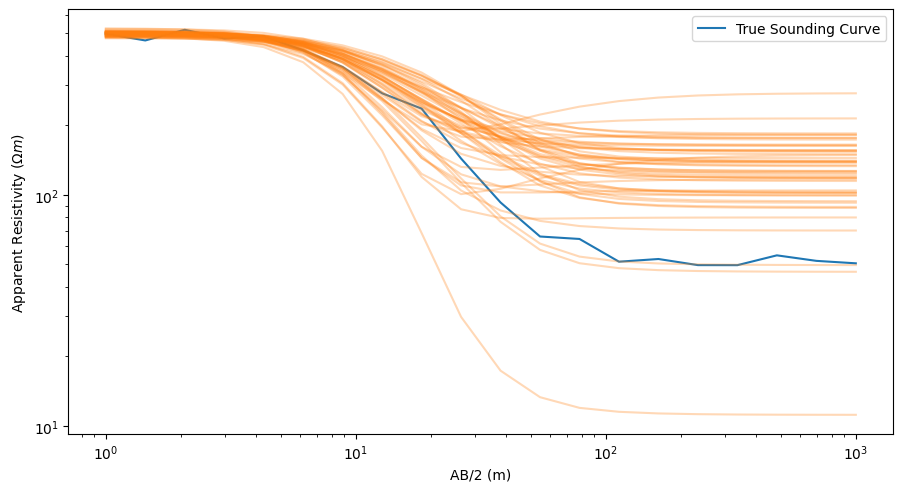

In [52]:
# Sample from the posterior distribution
posterior_samples_noise = posterior__4.sample((10000,), x=apparent_resistivities_textbook_noise, show_progress_bars=False)
# plot Posterior samples
_ = analysis.pairplot(posterior_samples_noise,points= torch.tensor([500,200, 50]), figsize=(10,8))

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook_noise, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples_noise[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing, app_res, color='#ff7f0e',  alpha=0.3)
  


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()


### 5. Run on 20 measurements but with more trainings iterations - with noise

In [57]:
infer_model = False
filename_experiment_5 = "pickle/sbi_models/5__ptx_20meas_5000sim_1000prior.pkl"

if infer_model: 
    
    num_dim = 3
    prior_min = torch.as_tensor([0, 0, 0])
    prior_max = torch.as_tensor([1000, 1000, 1000])
    
    # Define the prior as a BoxUniform distribution
    prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))
    # Define the prior and the simulator for sampling based on the wrapped forward model and the prior
    
    simulator, prior = prepare_for_sbi(dc_forward_model_for_sbi_fixed_resistivities, prior)
    
    posterior__5, theta__5, x__5, _ = sbi_wrapper(simulator, prior, 5000)
    pickle_objects([posterior__5, theta__5, x__5] ,filename_experiment_5)

else: 
    posterior__5, theta__5, x__5 = unpickle_objects(filename_experiment_5)


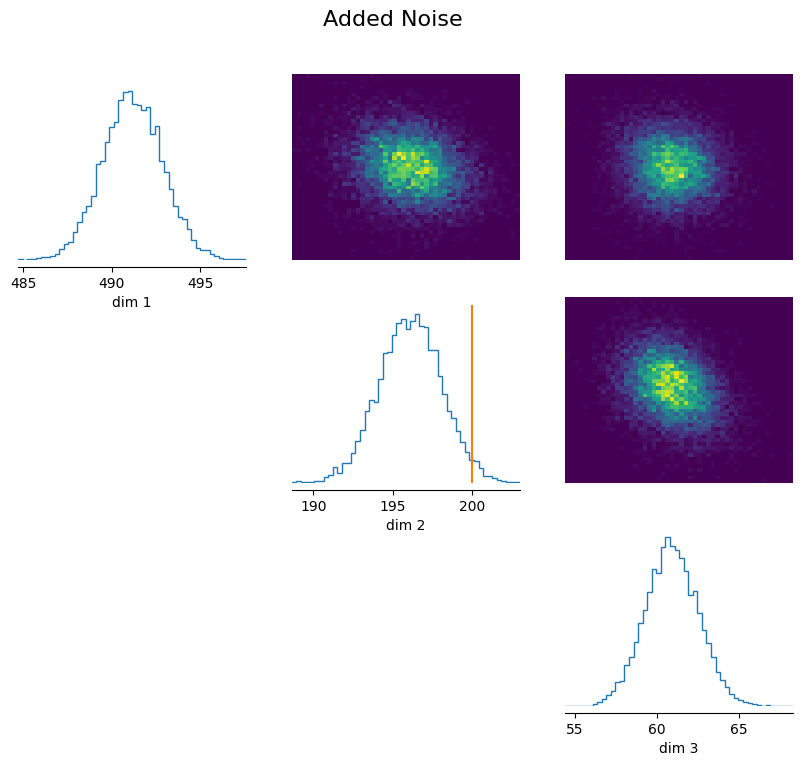

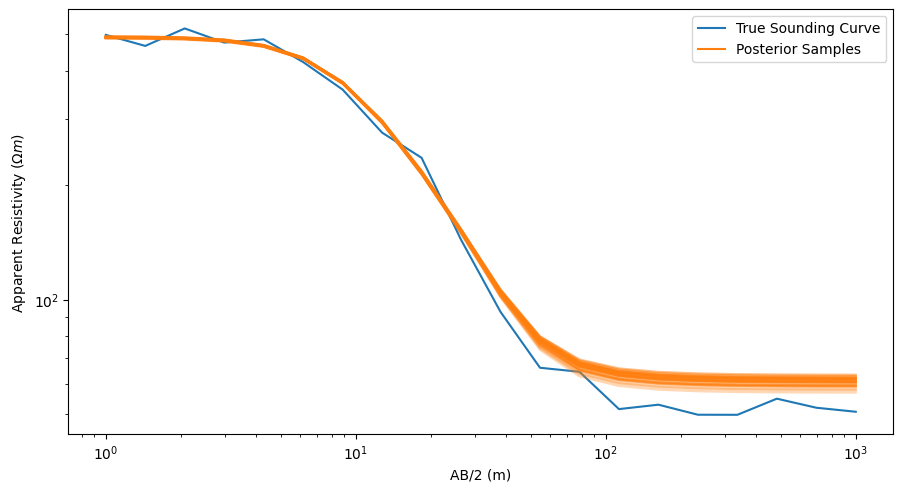

In [63]:
# Sample from the posterior distribution
posterior_samples_noise = posterior__5.sample((10000,), x=apparent_resistivities_textbook_noise, show_progress_bars=False)
_ = analysis.pairplot(posterior_samples_noise,points= torch.tensor([500,200, 50]), figsize=(10,8), title = "Added Noise")


fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook_noise, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples_noise[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing, app_res, color='#ff7f0e',  alpha=0.3)

ax1.plot([],[],  label='Posterior Samples')


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()

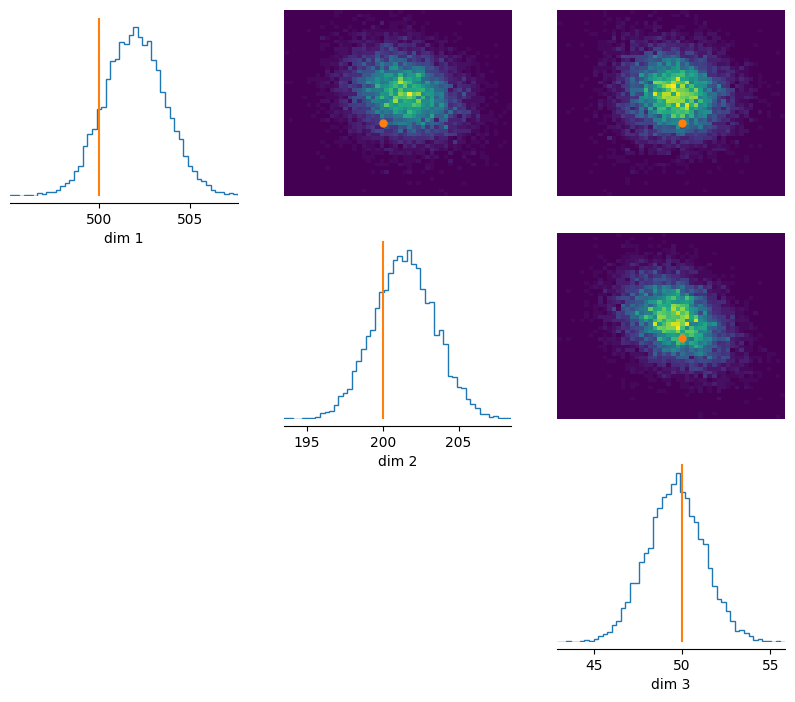

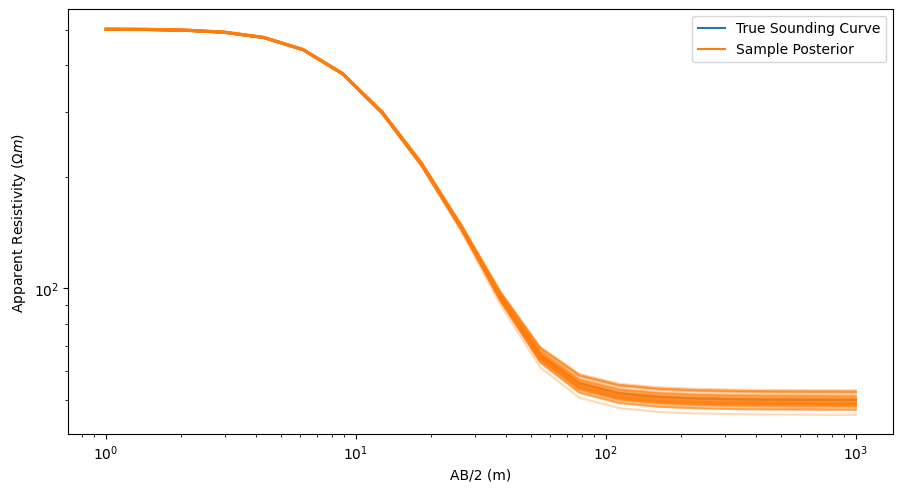

In [60]:
# Sample from the posterior distribution
posterior_samples = posterior__5.sample((10000,), x=apparent_resistivities_textbook, show_progress_bars=False, title = "No Noise")
_ = analysis.pairplot(posterior_samples,points= torch.tensor([500,200, 50]), figsize=(10,8))

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing, app_res, color='#ff7f0e',  alpha=0.3)

ax1.plot([],[],  label='Posterior Samples')


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()


### 6. Limiting the measurement distance

In [64]:
num_measurements = 20
max_spacing = 250

textbook_survey_250m, textbook_electrode_spacing_250m = schlumberger_survey(num_measurements, min_spacing, max_spacing)
apparent_resistivities_textbook_250m = dc_forward_model(earth_resistivities, earth_layer_thicknesses, textbook_survey_250m)
apparent_resistivities_textbook_250m_noise = add_noise(apparent_resistivities_textbook_250m)

def dc_forward_model_for_sbi_fixed_resistivities_250m(resistivities):
    return dc_forward_model(resistivities, earth_layer_thicknesses, textbook_survey_250m)

In [68]:
infer_model = False
filename_experiment_6 = "pickle/sbi_models/6__ptx_20meas_5000sim_1000prior_250m.pkl"

if infer_model:
    num_dim = 3
    prior_min = torch.as_tensor([0, 0, 0 ])
    prior_max = torch.as_tensor([1000, 1000, 1000 ])
    
    # Define the prior and the simulator for sampling based on the wrapped forward model and the prior
    prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))
    
    simulator, prior = prepare_for_sbi(dc_forward_model_for_sbi_fixed_resistivities_250m, prior)
    inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)
    theta__6, x__6 = simulate_for_sbi(simulator, proposal=prior, num_simulations=5000)
    
    inference = inference.append_simulations(theta__6, x__6)
    density_estimator = inference.train(force_first_round_loss=True)
    
    posterior__6 = inference.build_posterior(density_estimator)
    posterior_samples = posterior__6.sample((100000,), x=apparent_resistivities_textbook_250m)
    
    pickle_objects([posterior__6, theta__6, x__6], filename_experiment_6)
else: 
    posterior__6, theta__6, x__6 = unpickle_objects(filename_experiment_6)
    

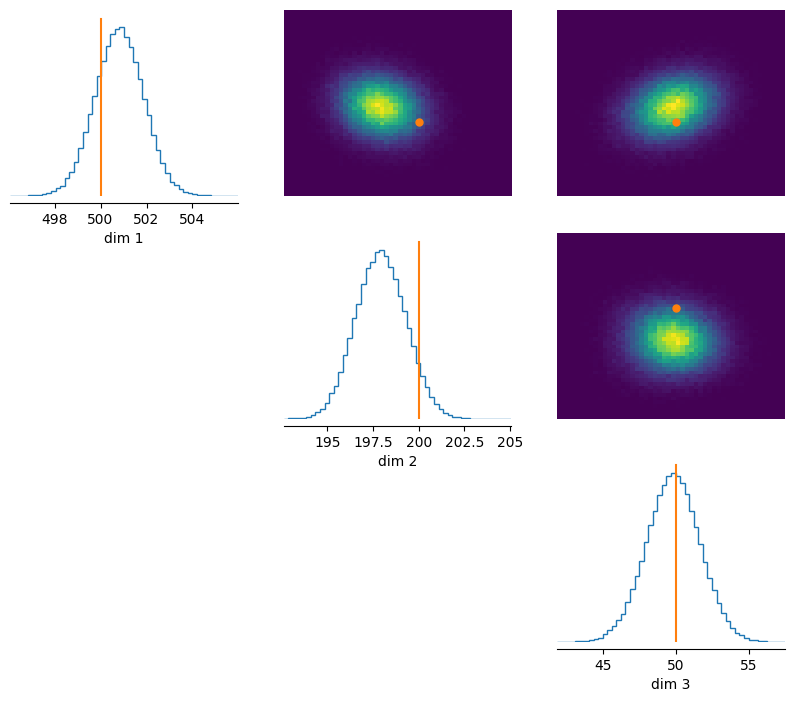

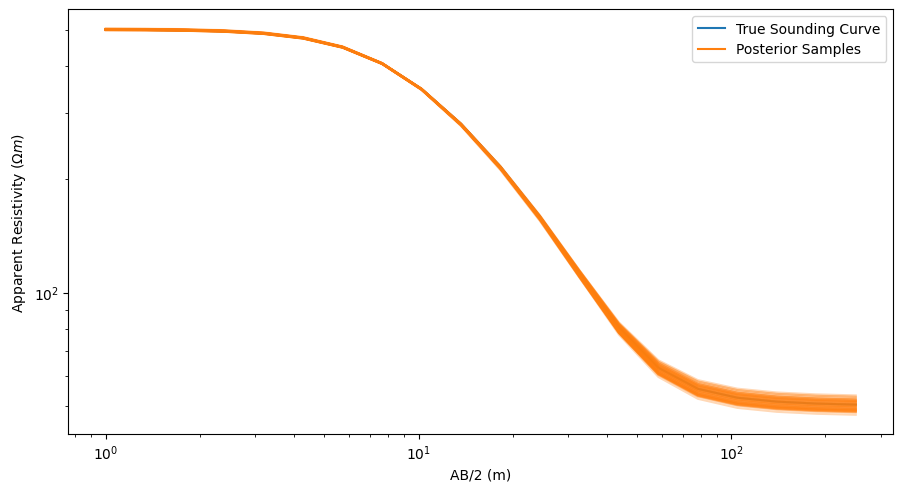

In [69]:
# Sample from the posterior distribution
# posterior_samples = posterior_250m.sample((10000,), x=apparent_resistivities_textbook_250m, show_progress_bars=False)
posterior_samples = posterior__6.sample((100000,), x=apparent_resistivities_textbook_250m, show_progress_bars=False)
_ = analysis.pairplot(posterior_samples,points= torch.tensor([500,200, 50]), figsize=(10,8))

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing_250m, apparent_resistivities_textbook_250m, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities_250m(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing_250m, app_res, color='#ff7f0e',  alpha=0.3)

ax1.plot([],[],  label='Posterior Samples')


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

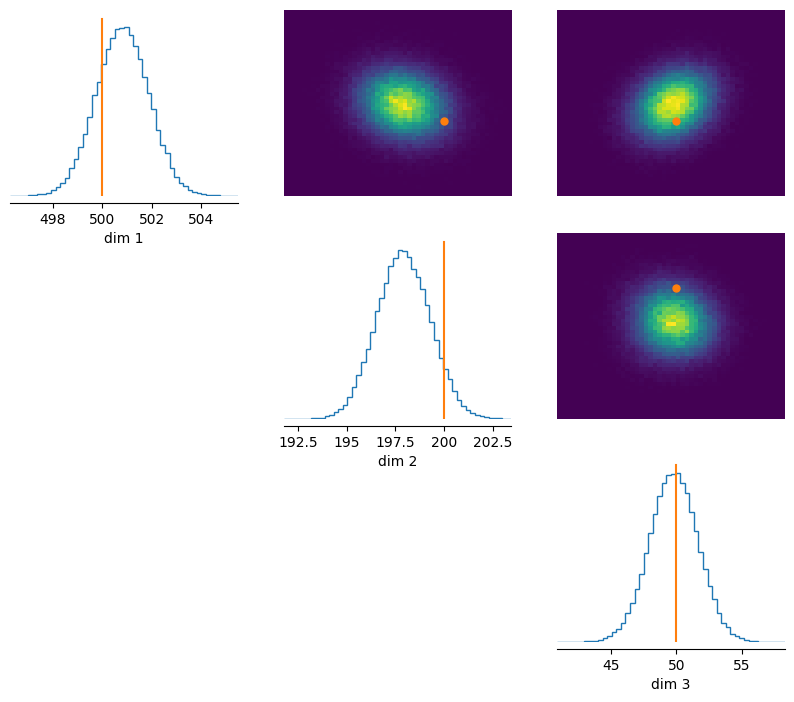

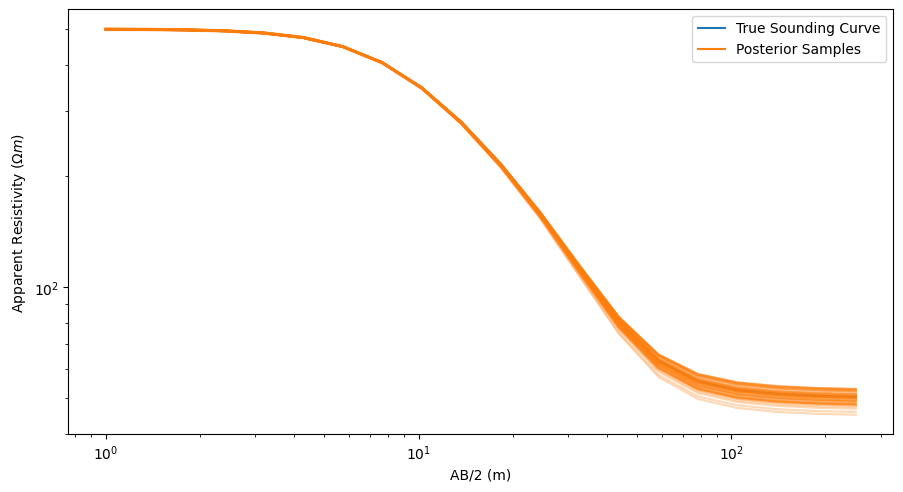

In [70]:
# Sample from the posterior distribution
posterior_samples = posterior__6.sample((10000,), x=apparent_resistivities_textbook_250m, show_progress_bars=False)
_ = analysis.pairplot(posterior_samples, points=torch.tensor([500, 200, 50]), figsize=(10, 8))

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing_250m, apparent_resistivities_textbook_250m, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities_250m(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing_250m, app_res, color='#ff7f0e',  alpha=0.3)

ax1.plot([],[],  label='Posterior Samples')


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()


### 7. Increasing the prior and the amount of simulations

In [71]:
infer_model = True
filename_experiment_7 = "pickle/sbi_models/7__ptx_20meas_5000sim_5000prior.pkl"
num_simulations = 5000

if infer_model:

    num_dim = 3
    prior_min = torch.as_tensor([0,0,0])
    prior_max = torch.as_tensor([5000, 5000, 5000])
    
    # Define the prior as a BoxUniform distribution
    prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))
    # Define the prior and the simulator for sampling based on the wrapped forward model and the prior
    
    simulator, prior = prepare_for_sbi(dc_forward_model_for_sbi_fixed_resistivities, prior)
    
    posterior__7, theta__7, x__7, inference = sbi_wrapper(simulator, prior, num_simulations)
  

'''    
    pickle_objects([posterior__4, theta__4, x__4], filename_experiment_4)
    
else:
    posterior__4, theta__4, x__4 = unpickle_objects(filename_experiment_4)
'''

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 122 epochs.

'    \n    pickle_objects([posterior__4, theta__4, x__4], filename_experiment_4)\n    \nelse:\n    posterior__4, theta__4, x__4 = unpickle_objects(filename_experiment_4)\n'

In [82]:
num_dim = 3
prior_min = torch.as_tensor([0,0,0])
prior_max = torch.as_tensor([5000, 5000, 5000])

# Define the prior as a BoxUniform distribution
prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))

In [84]:
inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)
# Simulate the forward model num_simulations many times from the wrapped forward model an
theta__7_2, x__7_2 = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [86]:
theta_inference = torch.cat((theta__7, theta__7_2), dim=0)
x_inference = torch.cat((x__7, x__7_2), dim=0)

inference = inference.append_simulations(theta_inference, x_inference)

In [87]:
# Train the inference object
density_estimator = inference.train()
# Build posterior from the inference object
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 129 epochs.

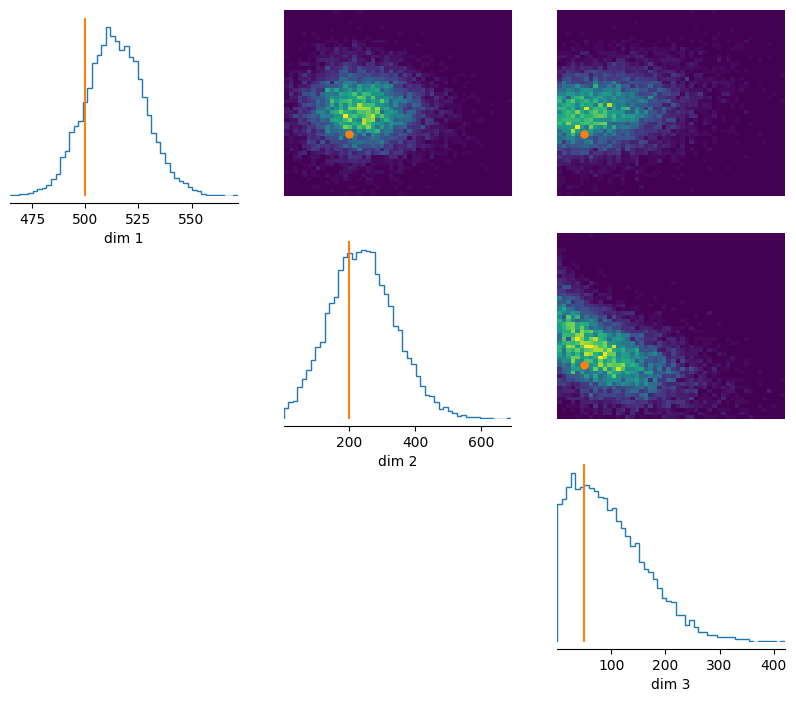

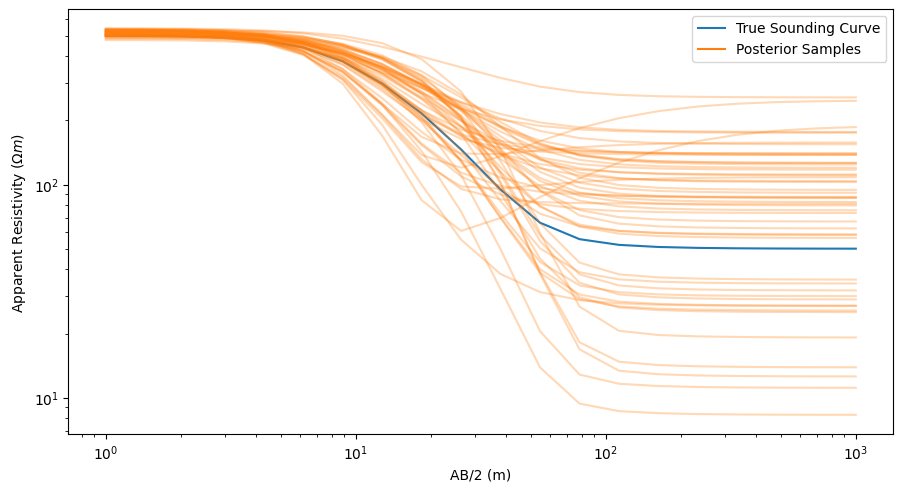

In [72]:
# Sample from the posterior distribution
posterior_samples = posterior__7.sample((10000,), x=apparent_resistivities_textbook, show_progress_bars=False)
_ = analysis.pairplot(posterior_samples, points=torch.tensor([500, 200, 50]), figsize=(10, 8))

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing, app_res, color='#ff7f0e',  alpha=0.3)

ax1.plot([],[],  label='Posterior Samples')


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()


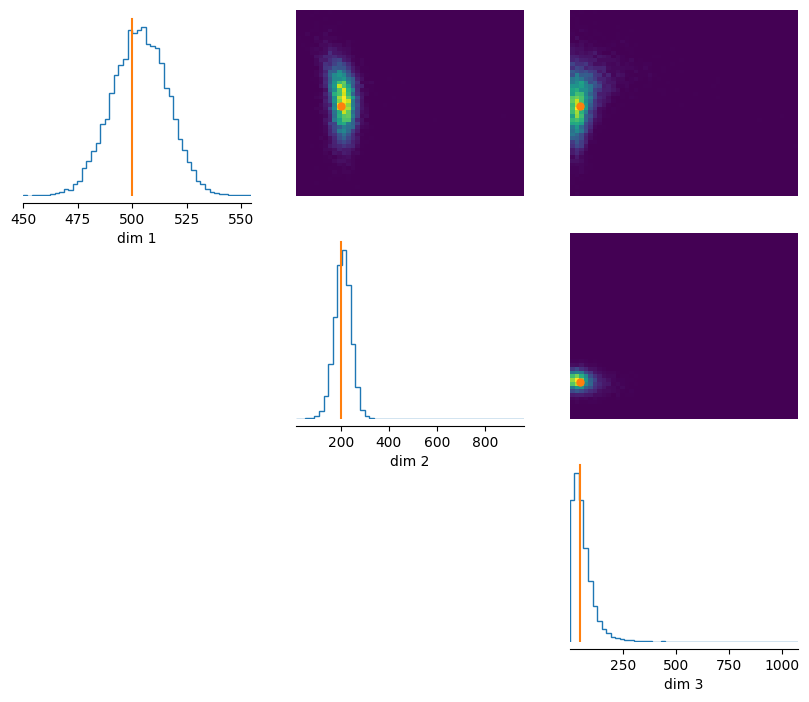

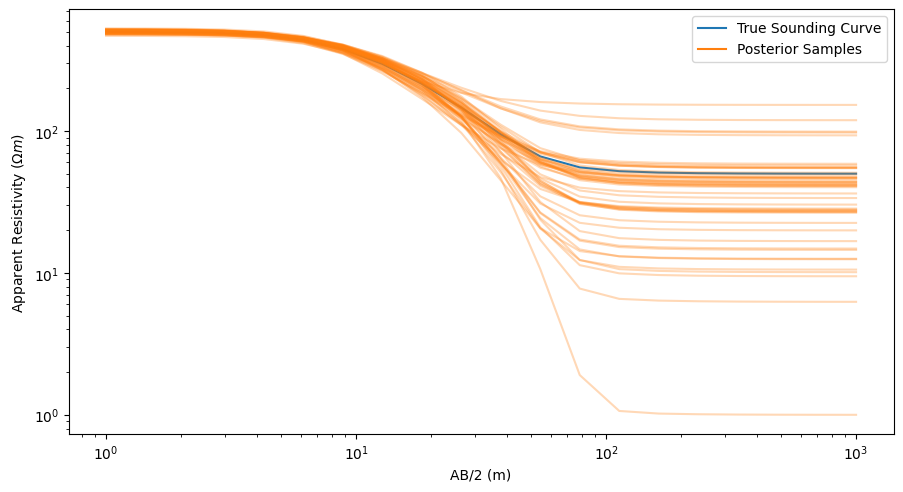

In [88]:
# Sample from the posterior distribution
posterior_samples = posterior.sample((10000,), x=apparent_resistivities_textbook, show_progress_bars=False)
_ = analysis.pairplot(posterior_samples, points=torch.tensor([500, 200, 50]), figsize=(10, 8))

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing, app_res, color='#ff7f0e',  alpha=0.3)

ax1.plot([],[],  label='Posterior Samples')


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()


In [89]:
# Simulate the forward model num_simulations many times from the wrapped forward model an
theta__7_3, x__7_3 = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [90]:
inference = inference.append_simulations(theta__7_3, x__7_3)

In [92]:
# Train the inference object
density_estimator = inference.train(force_first_round_loss=True)
# Build posterior from the inference object
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 57 epochs.

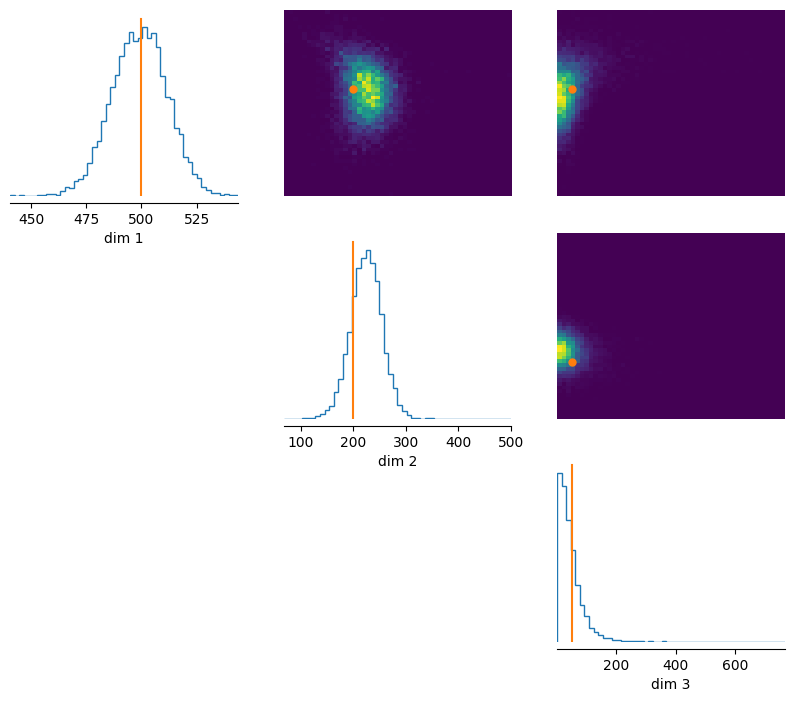

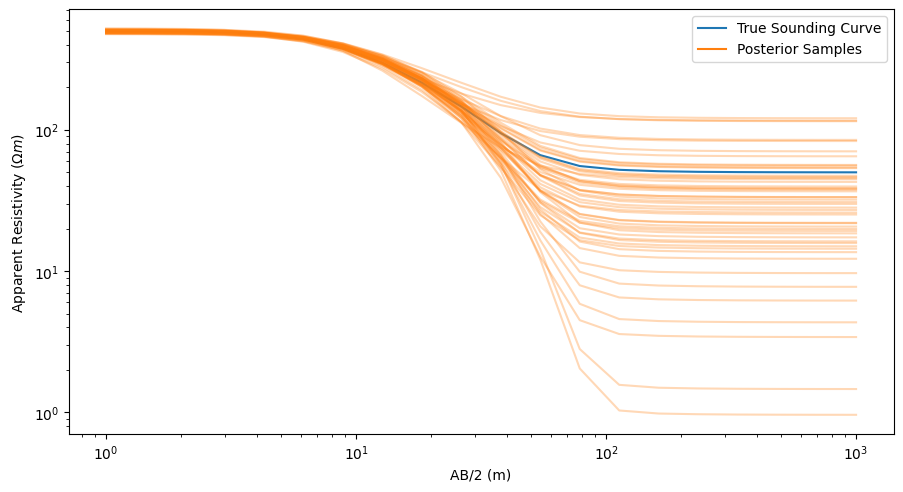

In [93]:
# Sample from the posterior distribution
posterior_samples = posterior.sample((10000,), x=apparent_resistivities_textbook, show_progress_bars=False)
_ = analysis.pairplot(posterior_samples, points=torch.tensor([500, 200, 50]), figsize=(10, 8))

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing, app_res, color='#ff7f0e',  alpha=0.3)

ax1.plot([],[],  label='Posterior Samples')


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()

In [94]:
# Simulate the forward model num_simulations many times from the wrapped forward model an
theta__7_4, x__7_4 = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
inference = inference.append_simulations(theta__7_4, x__7_4)
# Train the inference object
density_estimator = inference.train(force_first_round_loss=True)
# Build posterior from the inference object
posterior__7_4 = inference.build_posterior(density_estimator)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 48 epochs.

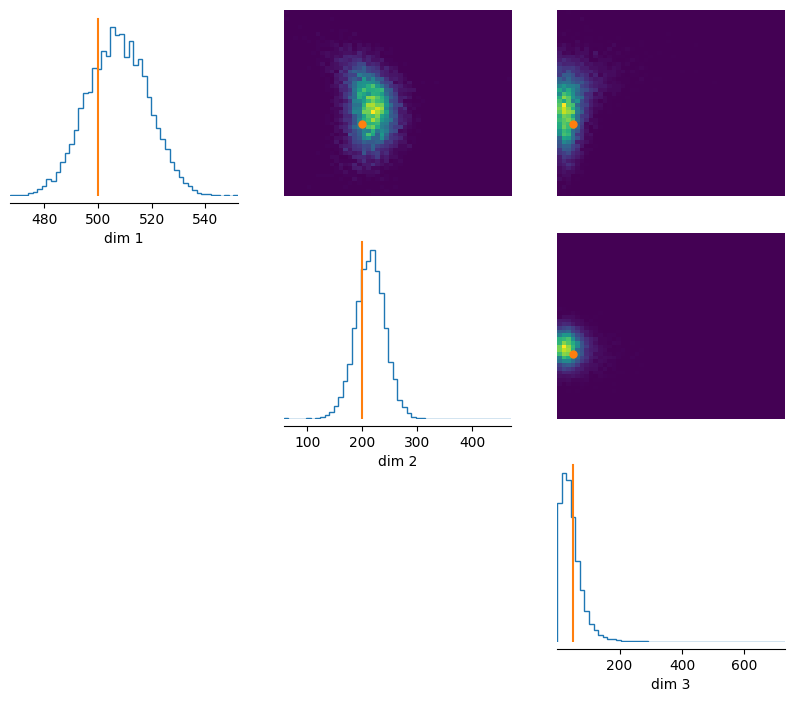

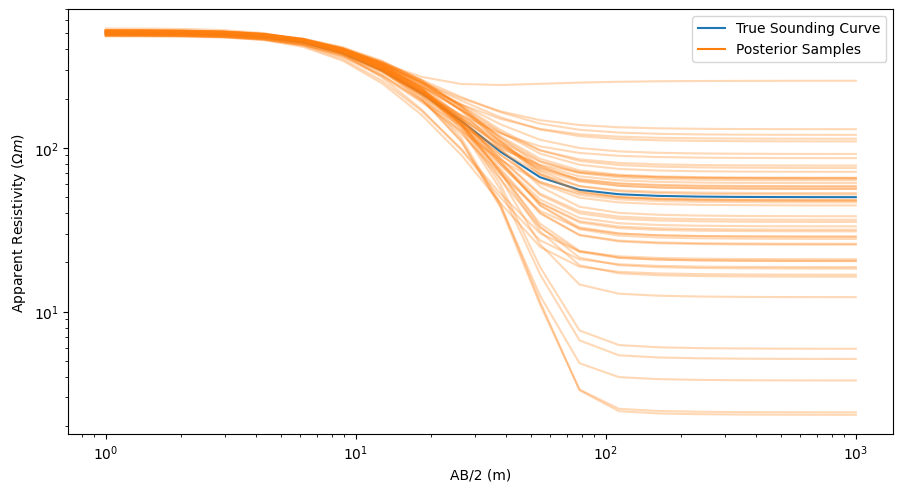

In [95]:
# Sample from the posterior distribution
posterior_samples = posterior__7_4.sample((10000,), x=apparent_resistivities_textbook, show_progress_bars=False)
_ = analysis.pairplot(posterior_samples, points=torch.tensor([500, 200, 50]), figsize=(10, 8))

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing, app_res, color='#ff7f0e',  alpha=0.3)

ax1.plot([],[],  label='Posterior Samples')


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()

In [96]:
# Simulate the forward model num_simulations many times from the wrapped forward model an
theta__7_5, x__7_5 = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
inference = inference.append_simulations(theta__7_5, x__7_5)
# Train the inference object
density_estimator = inference.train(force_first_round_loss=True)
# Build posterior from the inference object
posterior__7_5 = inference.build_posterior(density_estimator)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 47 epochs.

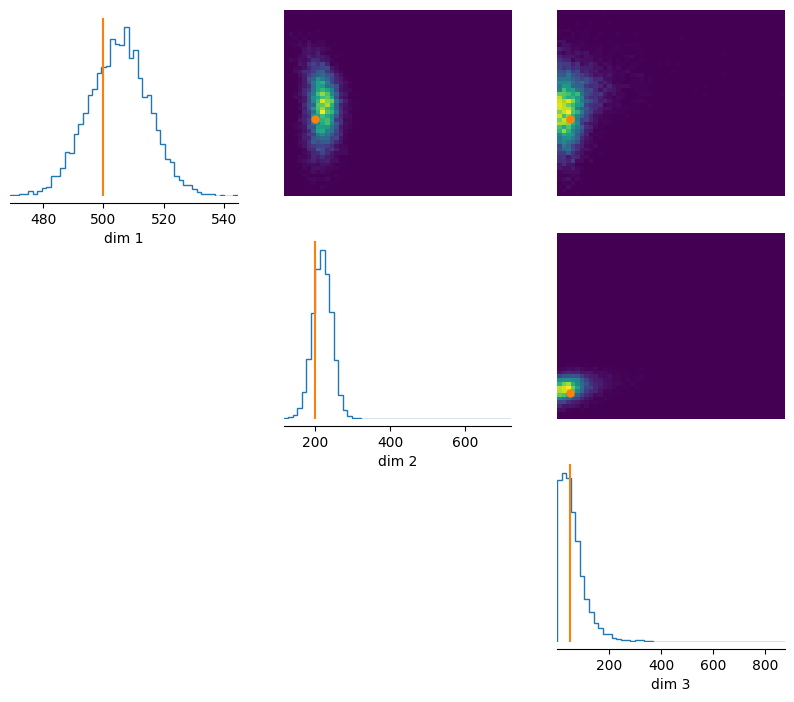

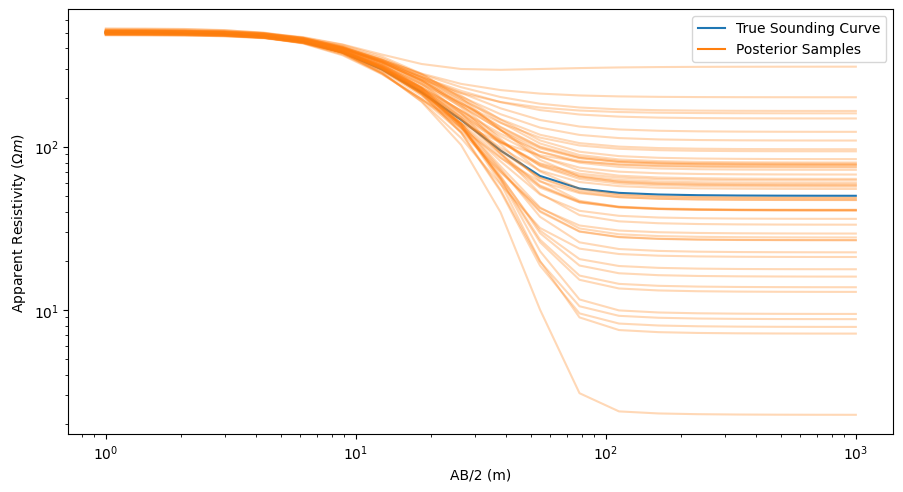

In [97]:
# Sample from the posterior distribution
posterior_samples = posterior__7_5.sample((10000,), x=apparent_resistivities_textbook, show_progress_bars=False)
_ = analysis.pairplot(posterior_samples, points=torch.tensor([500, 200, 50]), figsize=(10, 8))

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing, app_res, color='#ff7f0e',  alpha=0.3)

ax1.plot([],[],  label='Posterior Samples')


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()